## 1. Import libraries and requirements

In [1]:
# Loading required packages
import spacy
import pandas as pd
import re
# import gensim
# import gensim.downloader
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from gensim.models.phrases import Phrases, Phraser
# import nltk
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from statistics import mean
import json
import csv
import ast
import numpy as np

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings, ELMoEmbeddings

from tqdm import tqdm

# Set seed
seed = np.random.seed(1)


# Select Spacy model
# Efficiency
# nlp = spacy.load("en_core_web_sm")

# Accuracy
# nlp = spacy.load("en_core_web_trf")

# Change working directory
# %cd '/Users/richardfrissen/Documents/Maastricht University/Thesis/Development/Datasets'

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# Define columns and read annotated data
columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'like_num', 'lang', 'sentiment']
data = pd.read_csv('FULL_Annotation_data_output.tsv', sep='\t', nrows=500000, header = None)

In [ ]:
%%time

# Generate linguistic features for each token
def feature_extraction(input_column):
    features = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in input_column:
        i = str(i)
        doc = nlp(i)
        word = i
        for token in doc:
            features[0].append(token.pos)
            features[1].append(token.ent_type)
            features[2].append(token.is_alpha)
            features[3].append(token.is_ascii)
            features[4].append(token.is_digit)
            features[5].append(token.is_lower)
            features[6].append(token.is_upper)
            features[7].append(token.is_title)
            features[8].append(token.is_punct)
            features[9].append(token.is_space)
            features[10].append(token.like_num)
            features[11].append(token.is_oov)
            features[12].append(token.is_stop)
            features[13].append(token.lang)
            features[14].append(token.sentiment)
            features[15].append(len(word))
    return features

features = feature_extraction(data[0])

In [ ]:
%%time

# Convert list to dataframe
features = pd.DataFrame(features)

# We need to transpose this dataframe first
features = features.transpose()

# We concat the annotated data with the linguistic features
data = pd.concat([data, features], axis=1)
data.columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'lang', 'sentiment', 'word_length']

data.head(10)

In [ ]:
# Optionally the data can be saved to create a checkpoint

data.to_csv('data_features_full_dataset.csv', index = False)

data = pd.read_csv('data_features_full_dataset.csv', nrows=500000, header = 0)

data.shape

In [ ]:
data.head(10)

In [ ]:
# init word embedding
embedding = ELMoEmbeddings('medium')

In [ ]:
%%time

# Generate word embeddings for each token

def elmo_wordembed(input_column):
    elmo_result =[]
    counter = 0
    for i in tqdm(input_column):
        counter = counter +1
        try:
            i = str(i)
            token = Sentence(i)
            embedding.embed(token)
            for token in token:
                result_array = token.embedding
            result_list = result_array.tolist()
            elmo_result.append(result_list)
        except KeyError:
            elmo_result.append(np.nan)
        except TypeError: 
            elmo_result.append(np.nan)
        except IndexError:
            elmo_result.append(np.nan)

    return elmo_result


# ELMo_Word_Embeddings
word_embedding = elmo_wordembed(data['Token'])

In [ ]:
len(word_embedding)

In [ ]:
# Optionally the data can be saved to create a checkpoint

import pickle

f = open('word_embedding_elmo.pckl', 'wb')
pickle.dump(word_embedding, f)
f.close()

f = open('word_embedding_elmo.pckl', 'rb')
word_embedding = pickle.load(f)
f.close()

In [ ]:
%%time

# Replace empty values in the list of word embeddings for words 
# we couldn't generate a word embedding for

word_embedding_complete = []

for i in tqdm(word_embedding):
    try:
        if len(i) == 0:
            i = []
        else:
            i = i
        word_embedding_complete.append(i)
        
    except TypeError:
        i = []
        word_embedding_complete.append(i)

In [ ]:
# Check and verify length
# Length must be the same as the nrows of the dataframe

len(word_embedding_complete)

In [ ]:
%%time

# Convert list to dataframe
word_embedding_df = pd.DataFrame(word_embedding)
word_embedding_series = word_embedding_df[0].apply(pd.Series)

# We concat the annotated data with the linguistic features
data = pd.concat([data, word_embedding_series], axis=1)

In [ ]:
data.head(10)

In [4]:
%%time

# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_wordembedding_elmo.csv', index = False)

data = pd.read_csv('data_features_full_wordembedding_elmo.csv', nrows=500000, na_values=['nan'])

data.head(10)

CPU times: user 2min 48s, sys: 13.2 s, total: 3min 1s
Wall time: 3min 16s


,Token,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,food,O,92,0,True,True,False,True,False,False,...,-0.362660,0.038647,-0.329854,0.507664,0.011485,-0.299479,-1.018636,1.331968,0.502126,-0.005587
1,a,O,90,0,True,True,False,True,False,False,...,0.136579,-0.087388,-0.565916,0.522235,-0.452233,-0.057982,-0.515886,0.859544,0.378656,0.303306
2,fast,O,86,0,True,True,False,True,False,False,...,-0.169968,0.237214,-0.226488,0.113207,-0.221394,0.119126,-0.395318,1.134955,-0.326653,0.157859
3,grow,O,100,0,True,True,False,True,False,False,...,0.004376,0.560592,-0.205904,0.210360,-0.490179,-0.910097,-0.732791,0.366863,0.584376,-0.171481
4,-winne,O,97,0,False,True,False,True,False,False,...,0.258308,-0.018983,-0.428032,0.907898,-0.095798,-0.122752,-0.746413,0.754866,0.268109,-0.523803
5,online,O,86,0,True,True,False,True,False,False,...,-0.244042,0.146873,-0.418024,0.068457,-0.217877,-0.220068,-0.674808,0.997628,0.111707,-0.457278
6,food,O,92,0,True,True,False,True,False,False,...,-0.365108,0.043319,-0.345948,0.509963,0.019733,-0.303730,-1.015588,1.334889,0.503644,-0.022480
7,community,O,92,0,True,True,False,True,False,False,...,1.109663,0.207417,0.261030,0.897862,-0.075947,-0.136039,-2.038073,0.420835,0.835099,-0.125490
8,and,O,89,0,True,True,False,True,False,False,...,-0.158997,-0.092389,-0.442418,-0.399130,-0.244655,-0.091644,-0.268837,0.890471,-0.268504,-0.128473
9,crowd,O,92,0,True,True,False,True,False,False,...,-0.280942,0.728471,0.065729,0.598478,-0.002546,0.173746,-1.592165,0.661048,0.177235,-0.713160


In [5]:
%%time

# Replace NaN values with a "0"

data = data.replace(np.nan, '0', regex=True)

# We drop the token, as it is no longer needed for prediction
data.drop('Token', axis=1, inplace=True)
data.head(10)

CPU times: user 1.99 s, sys: 1.43 s, total: 3.42 s
Wall time: 3.46 s


,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,O,92,0,True,True,False,True,False,False,False,...,-0.362660,0.038647,-0.329854,0.507664,0.011485,-0.299479,-1.018636,1.331968,0.502126,-0.005587
1,O,90,0,True,True,False,True,False,False,False,...,0.136579,-0.087388,-0.565916,0.522235,-0.452233,-0.057982,-0.515886,0.859544,0.378656,0.303306
2,O,86,0,True,True,False,True,False,False,False,...,-0.169968,0.237214,-0.226488,0.113207,-0.221394,0.119126,-0.395318,1.134955,-0.326653,0.157859
3,O,100,0,True,True,False,True,False,False,False,...,0.004376,0.560592,-0.205904,0.210360,-0.490179,-0.910097,-0.732791,0.366863,0.584376,-0.171481
4,O,97,0,False,True,False,True,False,False,False,...,0.258308,-0.018983,-0.428032,0.907898,-0.095798,-0.122752,-0.746413,0.754866,0.268109,-0.523803
5,O,86,0,True,True,False,True,False,False,False,...,-0.244042,0.146873,-0.418024,0.068457,-0.217877,-0.220068,-0.674808,0.997628,0.111707,-0.457278
6,O,92,0,True,True,False,True,False,False,False,...,-0.365108,0.043319,-0.345948,0.509963,0.019733,-0.303730,-1.015588,1.334889,0.503644,-0.022480
7,O,92,0,True,True,False,True,False,False,False,...,1.109663,0.207417,0.261030,0.897862,-0.075947,-0.136039,-2.038073,0.420835,0.835099,-0.125490
8,O,89,0,True,True,False,True,False,False,False,...,-0.158997,-0.092389,-0.442418,-0.399130,-0.244655,-0.091644,-0.268837,0.890471,-0.268504,-0.128473
9,O,92,0,True,True,False,True,False,False,False,...,-0.280942,0.728471,0.065729,0.598478,-0.002546,0.173746,-1.592165,0.661048,0.177235,-0.713160


In [6]:
%%time

# 80% / 20% split
# Train, Test = train_test_split(data1, test_size=0.2, shuffle=False)

X = data.drop(['Label'],axis=1).values # independant features
y = data['Label'].values # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

CPU times: user 43 s, sys: 26.5 s, total: 1min 9s
Wall time: 1min 11s


In [7]:
# Delete data to save memory

del(data)

In [8]:
X_train.shape, y_train.shape

((400000, 1552), (400000,))

In [9]:
X_test.shape, y_test.shape

((100000, 1552), (100000,))

In [10]:
%%time

max_iterations = 1000000000

classifier = []
accuracy = []
precision = []
recall = []
f1 = []

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 23.1 µs


In [ ]:
%%time
# Baseline

clf = DummyClassifier(strategy="uniform", random_state=seed)


# Model fit
clf.fit(X_train, y_train)

In [11]:
# Optionally the data can be saved to create a checkpoint - Baseline

import pickle

f = open('elmo_baseline.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_baseline.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.16662
Precision: 0.16669788143411368
Recall: 0.16315833387324433
F1_score: 0.05833372562723548


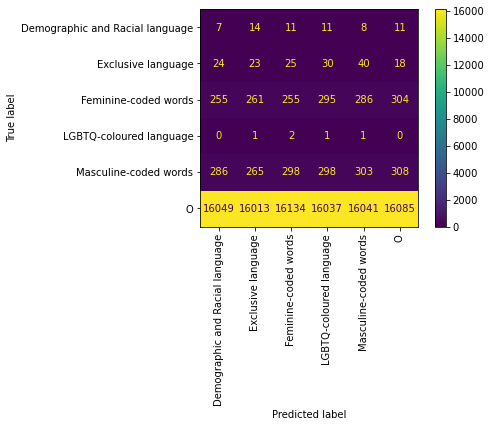

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.15      0.00        62
             Exclusive language       0.00      0.13      0.00       160
           Feminine-coded words       0.02      0.18      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.02      0.15      0.03      1758
                              O       0.96      0.17      0.28     96359

                       accuracy                           0.17    100000
                      macro avg       0.17      0.16      0.06    100000
                   weighted avg       0.93      0.17      0.27    100000



In [12]:
# Evaluation Baseline

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("Baseline")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal SVM parameters

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}
# grid_search = GridSearchCV(svm.SVC(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time
# Support Vector Machine
# best: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = svm.SVC(kernel='rbf', random_state=seed, max_iter=max_iterations, C=10, gamma=1)
scores_SVM = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
SVM_avg_precision = mean(scores_SVM['test_precision_macro'])
SVM_avg_recall = mean(scores_SVM['test_recall_macro'])
SVM_avg_f1 = mean(scores_SVM['test_f1_macro'])

print(SVM_avg_precision)
print(SVM_avg_recall)
print(SVM_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [13]:
# Optionally the data can be saved to create a checkpoint - SVM

import pickle

f = open('elmo_svm.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_svm.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99648
Precision: 0.9950376375976613
Recall: 0.82015091583306
F1_score: 0.8928811516791271


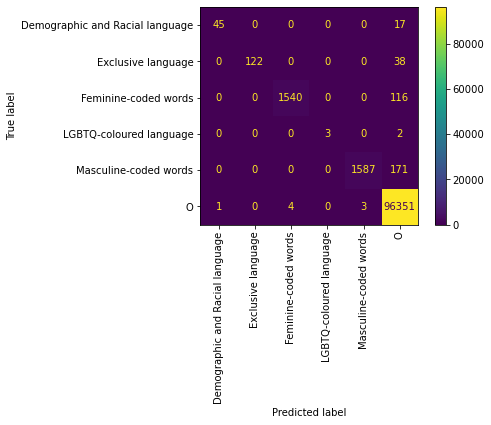

                                 precision    recall  f1-score   support

Demographic and Racial language       0.98      0.73      0.83        62
             Exclusive language       1.00      0.76      0.87       160
           Feminine-coded words       1.00      0.93      0.96      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      0.90      0.95      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.82      0.89    100000
                   weighted avg       1.00      1.00      1.00    100000



In [14]:
# Evaluation Support Vector Machine

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("SVM")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Logistic Regression settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# penaltys = ['l1', 'l2', 'elasticnet']
# param_grid = {'C': Cs, 'penalty' : penaltys, 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
# grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time

# Logistic Regression

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = LogisticRegression(solver='newton-cg', random_state=seed, max_iter=max_iterations)
scores_LR = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
LR_avg_precision = mean(scores_LR['test_precision_macro'])
LR_avg_recall = mean(scores_LR['test_recall_macro'])
LR_avg_f1 = mean(scores_LR['test_f1_macro'])

print(LR_avg_precision)
print(LR_avg_recall)
print(LR_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [15]:
# Optionally the data can be saved to create a checkpoint - LR

import pickle

f = open('elmo_lr.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_lr.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


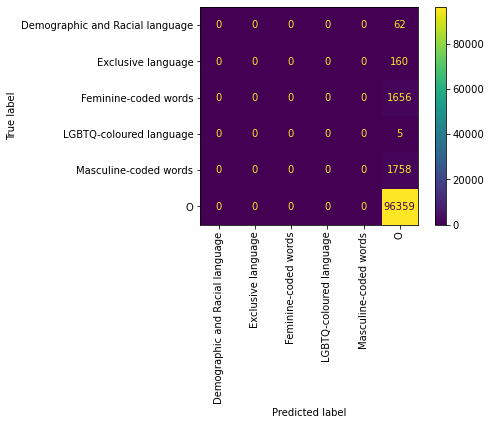

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Evaluation Logistic Regression

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("LR")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Decision Tree

# Cross validation
scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = DecisionTreeClassifier(random_state=seed)
scores_DT = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
DT_avg_precision = mean(scores_DT['test_precision_macro'])
DT_avg_recall = mean(scores_DT['test_recall_macro'])
DT_avg_f1 = mean(scores_DT['test_f1_macro'])

print(DT_avg_precision)
print(DT_avg_recall)
print(DT_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [17]:
# Optionally the data can be saved to create a checkpoint - DT

import pickle

f = open('elmo_dt.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_dt.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99871
Precision: 0.9640454735653803
Recall: 0.9225338524485386
F1_score: 0.9345947304777206


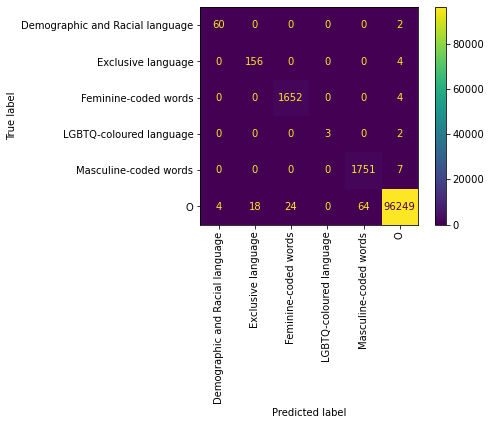

                                 precision    recall  f1-score   support

Demographic and Racial language       0.94      0.97      0.95        62
             Exclusive language       0.90      0.97      0.93       160
           Feminine-coded words       0.99      1.00      0.99      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       0.96      1.00      0.98      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       0.96      0.92      0.93    100000
                   weighted avg       1.00      1.00      1.00    100000



In [18]:
# Evaluation Decision Tree

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("DT")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Random Forest

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = RandomForestClassifier(random_state=seed)
scores_RF = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
RF_avg_precision = mean(scores_RF['test_precision_macro'])
RF_avg_recall = mean(scores_RF['test_recall_macro'])
RF_avg_f1 = mean(scores_RF['test_f1_macro'])

print(RF_avg_precision)
print(RF_avg_recall)
print(RF_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [19]:
# Optionally the data can be saved to create a checkpoint - RF

import pickle

f = open('elmo_rf.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_rf.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99981
Precision: 0.9964698269307664
Recall: 0.9245261689335983
F1_score: 0.9521389390732861


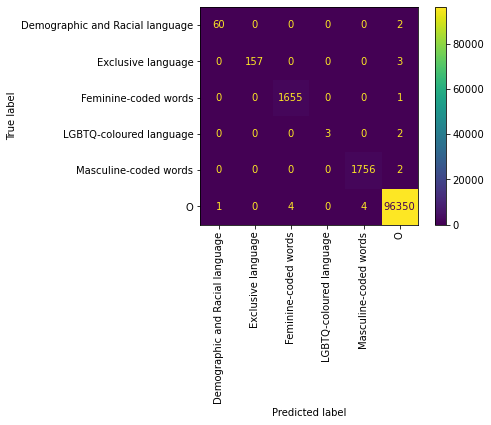

                                 precision    recall  f1-score   support

Demographic and Racial language       0.98      0.97      0.98        62
             Exclusive language       1.00      0.98      0.99       160
           Feminine-coded words       1.00      1.00      1.00      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      1.00      1.00      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.92      0.95    100000
                   weighted avg       1.00      1.00      1.00    100000



In [20]:
# Evaluation Random Forest

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("RF")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Neural network MLP settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# activations = ['identity', 'logistic', 'tanh', 'relu']
# alphas = [0.0001, 0.001, 00.1, 0.1, 1]
# param_grid = {'activation': activations, 'alpha' : alphas, 'solver': ('lbfgs', 'sgd', 'adam'), 'learning_rate': ('constant', 'invscaling', 'adaptive')}
# grid_search = GridSearchCV(MLPClassifier(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time

# Neural network MLP

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = MLPClassifier(solver='adam', random_state=seed)
scores_NN = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NN_avg_precision = mean(scores_NN['test_precision_macro'])
NN_avg_recall = mean(scores_NN['test_recall_macro'])
NN_avg_f1 = mean(scores_NN['test_f1_macro'])

print(NN_avg_precision)
print(NN_avg_recall)
print(NN_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [21]:
# Optionally the data can be saved to create a checkpoint - MLP

import pickle

f = open('elmo_mlp.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_mlp.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


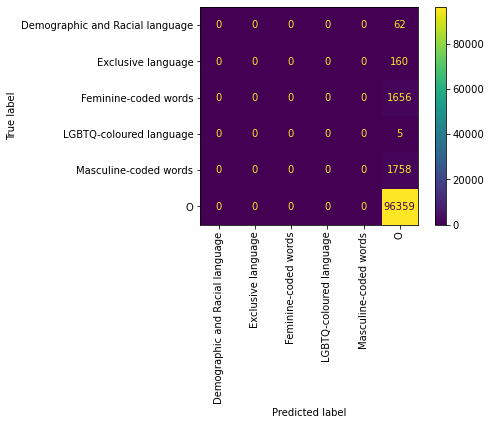

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Evaluation Neural network MLP

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("MLP")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Naive Bayes

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = GaussianNB()
scores_NB = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NB_avg_precision = mean(scores_NB['test_precision_macro'])
NB_avg_recall = mean(scores_NB['test_recall_macro'])
NB_avg_f1 = mean(scores_NB['test_f1_macro'])

print(NB_avg_precision)
print(NB_avg_recall)
print(NB_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [23]:
# Optionally the data can be saved to create a checkpoint - NB

import pickle

f = open('elmo_nb.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('elmo_nb.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.0166
Precision: 0.16942677707108286
Recall: 0.16667358523853507
F1_score: 0.005444128152409039


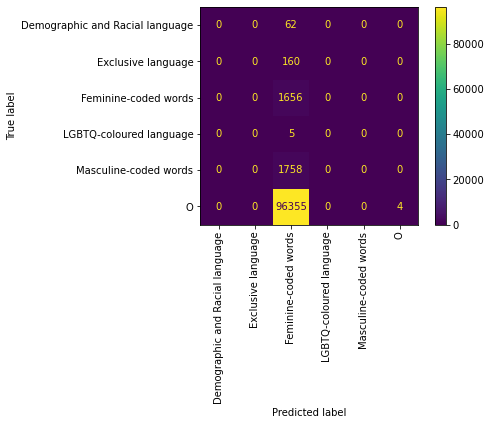

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.02      1.00      0.03      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       1.00      0.00      0.00     96359

                       accuracy                           0.02    100000
                      macro avg       0.17      0.17      0.01    100000
                   weighted avg       0.96      0.02      0.00    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Evaluation Naive Bayes

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("NB")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [25]:
results = pd.DataFrame(zip(classifier, accuracy, precision, recall, f1), columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results = results.sort_values(by = "F1-score", ascending = False)

f = open('elmo_results.pckl', 'wb')
pickle.dump(results, f)
f.close()

f = open('elmo_results.pckl', 'rb')
results = pickle.load(f)
f.close()

print(results)

  Classifier  Accuracy  Precision    Recall  F1-score
4         RF   0.99981   0.996470  0.924526  0.952139
3         DT   0.99871   0.964045  0.922534  0.934595
1        SVM   0.99648   0.995038  0.820151  0.892881
2         LR   0.96359   0.160598  0.166667  0.163576
5        MLP   0.96359   0.160598  0.166667  0.163576
0   Baseline   0.16662   0.166698  0.163158  0.058334
6         NB   0.01660   0.169427  0.166674  0.005444


In [26]:
# Save results dataframe

results.to_csv('elmo_results.csv', index = False)